<a href="https://colab.research.google.com/github/phipyao/ds3001-project_voting/blob/main/project_voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project #3 - Project Voting

# Research Question

Which party will Virginia counties vote for in a future presidential election?

# Summary

Summary

# Data

We used three datasets, a shapefile of the Virginia counties which we titled GDF, a table containing rows of the outcomes of each party with the total votes in a given region which we titled VDF, and lastly a table with rows of each region and the regions adjacent to it which was titled CDF. GDF contains 13 columns, most of which define the geometry of the corresponding region. It also contains the FIPS of the region which is a unique identifier we will later use to merge with the other datasets. VDF contains 13 columns as well. The ones we will focus on for this one are county_fips, party, and candidatevotes though the whole table will be merged. CDF has 16 columns though not every column is useful because some regions do not have as many neighbours as others so many cells are NaN. This dataset also contains the virginia district of a given region. As stated previously, in order to use this data we need to transform it slightly and combine them together.

In [ ]:
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.ensemble import RandomForestRegressor

We begin by importing like normal, though we use the geopandas library here to read the shx file which we haven't used previously.

In [ ]:
gdf = gpd.read_file('./va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx')
vdf = pd.read_csv('./data/voting_VA.csv')
cdf = pd.read_csv('./data/county_adjacencies.csv')

We start by merging CDF on to GDF using the FIPS column. This column for GDF had to be created as the given column wasn't of numeric type.

In [ ]:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')

The next transformation we must do is take each unique year in VDF (the end of each election term i.e. 2000, 2004, ...) and sum the total number of democratic and republicans votes over each region. This is recorded on our main dataframe df as a column either dem_votes_{year} or rep_votes_{year}.

In [ ]:
for y in vdf['year'].unique():
    df20 = vdf.loc[ vdf['year']==y,:]

    Dvotes = df20.loc[(df20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
    Dvotes = Dvotes.rename('dem_votes_' + str(y))
    df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')

    Rvotes = df20.loc[(df20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
    Rvotes = Rvotes.rename('rep_votes_' + str(y))
    df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')

Next, we defined a helper function that easily extracts the votes for all years for a given region. We will use this later when creating our ensamble.

In [ ]:
#cleans data by extracting votes by year for each county
def extract_df(index):
    row = df.iloc[index]
    years = []
    dem_votes = []
    rep_votes = []

    for column in df.columns:
        if column.startswith('dem_votes'):
            year = column.split('_')[-1]
            years.append(year)
            dem_votes.append(row[column])
            rep_votes.append(row['rep_votes_' + year])

    result_df = pd.DataFrame({'dem_votes': dem_votes, 'rep_votes': rep_votes})
    result_df['vote_diff'] = result_df['rep_votes']-result_df['dem_votes']
    return result_df


# Results

## Ensemble

In [ ]:
def ensemble(df):
    # Split data into training rows and testing rows:
    N = df.shape[0]
    df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
    train_size = int(.8*N)
    df_train = df[0:train_size]
    N_train = df_train.shape[0]
    df_test = df[train_size:]
    N_test = df_test.shape[0]

    # Bootstrap:
    T = 300
    m_depth = 4
    Rsq = np.zeros(T) # preallocate the rsq measure
    y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set
    df_train.head()

    # Split data into train/test:
    X_train = df_train.drop(['vote_diff'],axis=1)
    y_train = df_train['vote_diff']
    X_test = df_test.drop(['vote_diff'],axis=1)
    y_test = df_test['vote_diff']

    for s in range(T):
        # Generate a bootstrap sample:
        df_s = df_train.sample(frac=1, replace=True)
        X_s = df_s.drop('vote_diff',axis=1)
        y_s = df_s['vote_diff']
        # Fit decision tree:
        cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
        cart = cart.fit(X_s, y_s) # Fit the classifier
        # Compute Rsq:
        y_hat = cart.predict(X_test)
        SSE = np.sum( (y_test-y_hat)**2 )
        TSS = np.sum( (y_test-y_s.mean())**2 )
        Rsq[s] = 1 - SSE/TSS
        # Make and Save Predictions:
        y_test_hat[s,:] = y_hat

    # Ensemble predictor:
    y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
    SSE = np.sum( (y_test-y_hat_ensemble)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq_ensemble = 1 - SSE/TSS

    # Classification Accuracy
    total_rows = len(y_test)
    correct_label_count = 0
    for i in range(total_rows):
      if y_test.iloc[i] * y_hat_ensemble[i] > 0:  # Check if signs are the same
          correct_label_count += 1

    return [Rsq_ensemble, y_hat_ensemble.mean(), correct_label_count, total_rows]


Takes the average of all the r-sqared values from each individual ensemble prediction from each county:

In [ ]:
results = []
region_accuracy = []

total_rows = 0
total_correct_label = 0

r_avg = 0
total = 0
for i in range(len(df)):
    ensemble_results = ensemble(extract_df(i))
    r_avg += ensemble_results[0]

    total_correct_label += ensemble_results[2]
    total_rows += ensemble_results[3]

    accuracy = ensemble_results[2] / ensemble_results[3]
    region_accuracy.append((df.loc[i, 'NAME'], accuracy))

    results.append(ensemble_results)
    total += 1

total_accuracy = total_correct_label / total_rows
r_avg /= total
print(r_avg)

0.19349498577017338
0.5


## Extracting Results

In [94]:
# Printing results used by manually comparing predicted labels and the winner they predict to actual
print(f'Classification Accuracy: {total_accuracy * 100}%')

for i in region_accuracy:
  print(f'{i[0]}: {i[1] * 100}%')

Classification Accuracy: 89.47368421052632%
Accomack: 100.0%
Albemarle: 50.0%
Alleghany: 100.0%
Amelia: 100.0%
Amherst: 100.0%
Appomattox: 100.0%
Arlington: 100.0%
Augusta: 100.0%
Bath: 100.0%
Bedford: 100.0%
Bland: 100.0%
Botetourt: 100.0%
Brunswick: 100.0%
Buchanan: 100.0%
Buckingham: 100.0%
Campbell: 100.0%
Caroline: 50.0%
Carroll: 100.0%
Charles City: 100.0%
Charlotte: 100.0%
Chesterfield: 50.0%
Clarke: 100.0%
Craig: 100.0%
Culpeper: 100.0%
Cumberland: 100.0%
Dickenson: 50.0%
Dinwiddie: 100.0%
Essex: 50.0%
Fairfax: 50.0%
Fauquier: 100.0%
Floyd: 100.0%
Fluvanna: 100.0%
Franklin: 100.0%
Frederick: 100.0%
Giles: 100.0%
Gloucester: 100.0%
Goochland: 100.0%
Grayson: 100.0%
Greene: 100.0%
Greensville: 100.0%
Halifax: 100.0%
Hanover: 100.0%
Henrico: 50.0%
Henry: 100.0%
Highland: 100.0%
Isle of Wight: 100.0%
James City: 50.0%
King and Queen: 100.0%
King George: 100.0%
King William: 100.0%
Lancaster: 100.0%
Lee: 100.0%
Loudoun: 100.0%
Louisa: 100.0%
Lunenburg: 100.0%
Madison: 100.0%
Mathews

It was found that over all the regions, the ultimate outcome (either Democrat or Republic) was predicted correct 89.47% of the time across the samples of  random years and regions created in our test set. We also included a breakdown of how the model performed with the accuracies of each individual region. It should be noted that because our data set was very small looking at a given region (six total years split into training set of size four and test set of size two), the individual accuracies can only be three distinct values: 0%, 50%, or 100%.

In [ ]:
def ensemble_result(i):
    return ensemble(extract_df(i))[1]

In [ ]:
df['predicted_vote_diff'] = df.index.map(ensemble_result)

In [ ]:
df.head()
df.columns

Index(['STCOFIPS', 'GNIS', 'NAME', 'NAMELSAD', 'GSOURCE', 'LADOPT',
       'LASTUPDATE', 'JURISTYPE', 'AREASQMI', 'Shape_Leng', 'Shape_Area',
       'geometry', 'FIPS_left', 'County', 'Population2022', 'FIPS', 'District',
       'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11',
       'N12', 'dem_votes_2000', 'rep_votes_2000', 'dem_votes_2004',
       'rep_votes_2004', 'dem_votes_2008', 'rep_votes_2008', 'dem_votes_2012',
       'rep_votes_2012', 'dem_votes_2016', 'rep_votes_2016', 'dem_votes_2020',
       'rep_votes_2020', 'predicted_vote_diff'],
      dtype='object')

Discretized Dem and Rep votes, taken with inverse hyperbolic sine of the predicted difference to deal with outliers:

In [ ]:
df['vote_diff_ihs'] = np.arcsinh(df['predicted_vote_diff'])

In [ ]:
df[['NAME', 'vote_diff_ihs']].head()

,NAME,vote_diff_ihs
0,Accomack,7.788096
1,Albemarle,-9.701737
2,Alleghany,8.087165
3,Amelia,8.278627
4,Amherst,8.843358


In [ ]:
# Predicted most Democratic leaning counties

df.sort_values(by=['vote_diff_ihs']).head(5)

,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,dem_votes_2008,rep_votes_2008,dem_votes_2012,rep_votes_2012,dem_votes_2016,rep_votes_2016,dem_votes_2020,rep_votes_2020,predicted_vote_diff,vote_diff_ihs
28,51059,1480119,Fairfax,Fairfax County,L,Y,2021-02-18,CO,406.622369,319248.326554,...,310359,200994,315273,206773,355133,157710,419943,168401,-124328.771667,-12.423832
124,51760,1789073,Richmond,Richmond City,L,Y,2023-05-22,CI,62.503974,103953.865965,...,73623,18649,75921,20050,81259,15581,92175,16603,-53230.585000,-11.575536
6,51013,1480097,Arlington,Arlington County,L,Y,2014-12-01,CO,26.064444,45014.932421,...,78994,29876,81269,34474,92016,20186,105344,22318,-51200.570000,-11.536653
118,51710,1498557,Norfolk,Norfolk City,L,Y,2017-01-25,CI,66.208849,287241.996174,...,62819,24814,62687,23147,57023,21552,64440,23443,-34175.840000,-11.132421
95,51510,1498415,Alexandria,Alexandria City,L,Y,2014-12-01,CI,15.350045,37172.277124,...,50473,19181,52199,20249,57242,13285,66240,14544,-32817.851667,-11.091875


In [ ]:
# Predicted most Republican leaning counties

df.sort_values(by=['vote_diff_ihs'], ascending=False).head(5)

,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,dem_votes_2008,rep_votes_2008,dem_votes_2012,rep_votes_2012,dem_votes_2016,rep_votes_2016,dem_votes_2020,rep_votes_2020,predicted_vote_diff,vote_diff_ihs
41,51085,1480132,Hanover,Hanover County,L,Y,2023-05-22,CO,472.560738,2.895262e+05,...,18447,37344,18294,39940,19382,39630,25307,44318,20625.650000,10.627438
20,51041,1480111,Chesterfield,Chesterfield County,V,N,2023-05-22,CO,438.209218,4.616775e+05,...,74310,86413,77694,90934,81074,85045,106935,93326,18132.216667,10.498593
9,51019,1674818,Bedford,Bedford County,L,Y,2021-09-23,CO,776.090456,2.691647e+05,...,11017,24420,10209,26679,9768,30659,12176,35600,16443.316667,10.400822
7,51015,1480098,Augusta,Augusta County,V,N,2014-08-01,CO,970.288077,3.069250e+05,...,9825,23120,9451,23624,8177,26163,10840,30714,15576.720000,10.346680
129,51810,1498559,Virginia Beach,Virginia Beach City,L,Y,2017-01-25,CI,408.144012,1.350634e+06,...,98885,100319,94299,99291,91032,98224,117393,105087,14531.420000,10.277216


<Axes: >

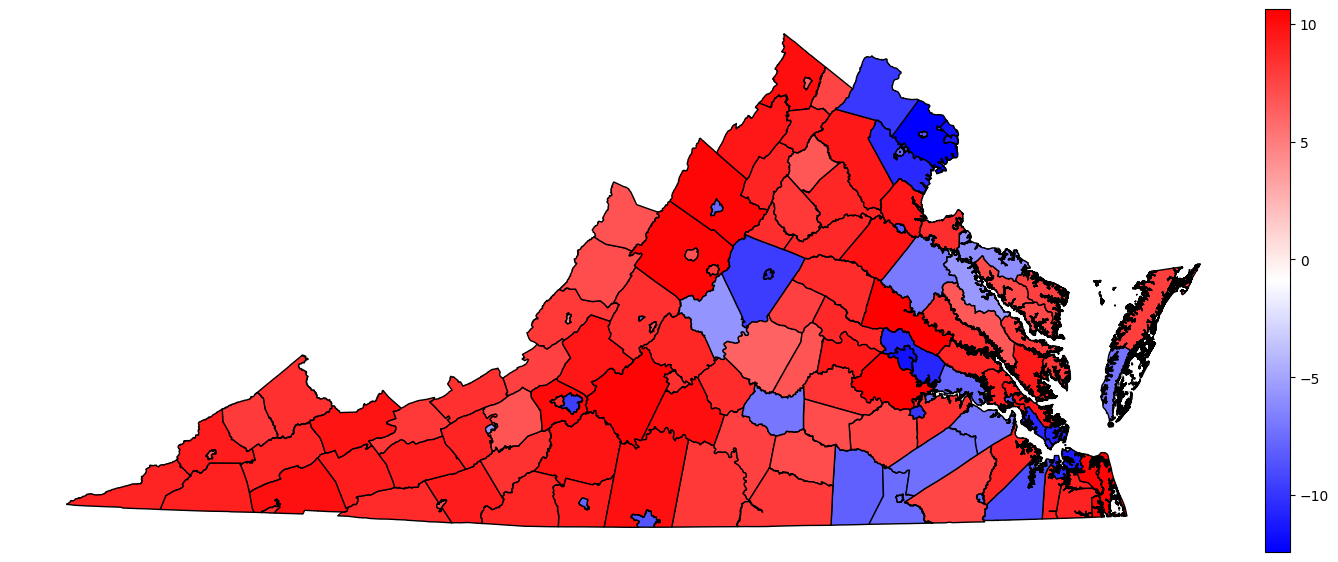

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff_ihs',legend=True,cax=cax,cmap='bwr',edgecolor='k')

<Axes: xlabel='population_ihs', ylabel='vote_diff_ihs'>

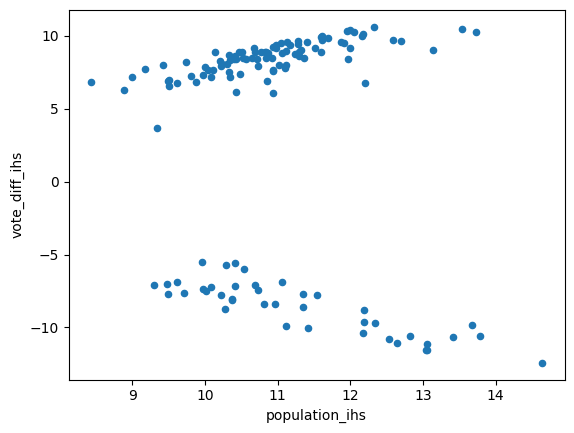

In [ ]:
# sinh population to ease spread out data
df['population_ihs'] = np.arcsinh(df['Population2022'])

df.plot.scatter(y='vote_diff_ihs', x='population_ihs')

In [ ]:
# compare which party will win based on which has a greater population of votes
dem_pop = 0
rep_pop = 0

for index, row in df.iterrows():
    if row['vote_diff_ihs'] > 0:
        rep_pop += row['Population2022']
    else:
        dem_pop += row['Population2022']

print(f"The predicted population vote for the Democratic party candidate is {dem_pop} and the predicted population vote for the Republican party candidate is {rep_pop}.")


The predicted population vote for the Democratic party candidate is 4524470 and the predicted population vote for the Republican party candidate is 4159160.


# Conclusion

Although our model did not perform the best on our test data, we were still able to create a prediction for the upcoming 2024 election using machine learning and analysis. It should be noted that the performance metric we chose, the R-squared value of the predicted vs. actual voting differential between a Democratic candidate and a Republican candidate, doesn’t reflect the accuracy of our classifications of each state. The value is low but this only means that the voting differential between parties wasn’t the most accurate, and not necessarily the predicted outcome. Our classification accuracy did show better results with an accuract of nearly 90%. So while we can't be assured that the predicted differentials will be accurate, we can be relatively confident in our generated map and results of the 2024 election with more evidence to back it up.


If we were to continue building on this project, we would try different analytic methods and use more relevant performance measures. Because we’re predicting the results of a future election, we don’t have a test set to validate against, and thus how we compare to past data is very important to ensuring confidence in our results for 2024. This can easily be misrepresented by a lack of data or improper analysis so to continue would be to evaluate many different performance metrics and discuss how they may or may not fit the research question better. One method may tell us our model performs better in predicting one particular area (like the number of people who ultimately vote) but misrepresent another area (like the ultimate voting outcome).
